In [627]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.datasets import fetch_california_housing
from sklearn.datasets import fetch_openml

import numpy as np

import torch
from torch import nn

import tensorflow as tf
from tensorflow import keras

# `Own Neural Net (ONN)`
___

In [628]:
class Layer_Dense:
    
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    # Forward pass
    def forward(self, inputs):       
        # Remember input values
        self.inputs = inputs
        
        # Calculate output values from inputs, weights and biases
        self.output = (inputs @ self.weights) + self.biases
    
    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [629]:
class Activation_ReLU:
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)
    
    # Backward pass
    def backward(self, dvalues):    
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()
        
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0 

In [630]:
class Activation_Sigmoid:
    
    # Forward pass
    def forward(self, inputs):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
        
    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

In [631]:
class Activation_Softmax:
    
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        self.output = probabilities     

    # Backward pass
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)

            # Calculate Jacobian matrix of the output and
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [632]:
class Loss:
    
    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):
        
        # Calculate sample losses
        sample_losses = self.forward(output, y)
        
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        
        # Return loss
        return data_loss

In [633]:
class Loss_CategoricalCrossentropy(Loss):
    
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)
        
        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        # Probabilities for target values - only if categorical labels
        correct_confidences = y_pred_clipped[range(samples), y_true]
        
        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        
        return negative_log_likelihoods
    
    # Backward pass
    def backward(self, dvalues, y_true):
        
        # Number of samples
        samples = len(dvalues)
        
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        
        # Turn labels into one-hot vector
        y_true_one_hot = np.eye(labels)[y_true]
        
        # Calculate gradient
        self.dinputs = -y_true_one_hot / (dvalues + 1e-15)
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [634]:
class Loss_MeanSquaredError(Loss):
    
    # Forward pass
    def forward(self, y_pred, y_true):
        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)
        
        # Return losses
        return sample_losses
    
    # Backward pass
    def backward(self, dvalues, y_true):        
        # Number of samples
        samples = len(dvalues)
        
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])
        
        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples

`Optimizers`

In [635]:
class Optimizer_SGD:
    
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
        self.current_learning_rate = learning_rate
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = \
                self.learning_rate * (1.0 / (1.0 + (self.decay * self.iterations)))
    
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                (self.current_learning_rate * layer.dweights)
            
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                (self.current_learning_rate * layer.dbiases)
            
            layer.weight_momentums = weight_updates
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iterations += 1

In [636]:
class Optimizer_Adagrad:
    
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))
            
    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / \
            (np.sqrt(layer.weight_cache) + self.epsilon)

        layer.biases += -self.current_learning_rate * layer.dbiases / \
            (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [637]:
class Optimizer_RMSprop:
    
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
        
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2
        
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * layer.dweights / \
            (np.sqrt(layer.weight_cache) + self.epsilon)

        layer.biases += -self.current_learning_rate * layer.dbiases / \
            (np.sqrt(layer.bias_cache) + self.epsilon)
        
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

In [638]:
class Optimizer_Adam:
    
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
        beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))
    
    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + \
            (1 - self.beta_1) * layer.dweights
        
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + \
            (1 - self.beta_1) * layer.dbiases
        
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        
        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
            weight_momentums_corrected / \
            (np.sqrt(weight_cache_corrected) + self.epsilon)
        
        layer.biases += -self.current_learning_rate * \
            bias_momentums_corrected / \
            (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

# `MNIST dataset`
___

In [379]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [380]:
x_train.shape, y_train.shape

((46900, 784), (46900,))

In [381]:
x_test.shape, y_test.shape

((23100, 784), (23100,))

# `PyTorch on MNIST`
___

In [639]:
def init_train_torch_mnist(
    W1, W2, W3,
    B1, B2, B3,
    x_train,
    y_train,
    x_test,
    y_test,
    lr,
    batch_size,
    epochs):
    
    losses, accs = [], []
    
    model = nn.Sequential(
                nn.Linear(784, 64),
                nn.ReLU(),
                nn.Linear(64, 64),
                nn.ReLU(),
                nn.Linear(64, 10),
                #nn.Softmax(dim=1)
            )
    
    model[0].weight.data = torch.Tensor(W1.T)
    model[0].bias.data = torch.Tensor(B1.reshape(-1, ))

    model[2].weight.data = torch.Tensor(W2.T)
    model[2].bias.data = torch.Tensor(B2.reshape(-1, ))

    model[4].weight.data = torch.Tensor(W3.T)
    model[4].bias.data = torch.Tensor(B3.reshape(-1, ))
    
    loss = nn.CrossEntropyLoss()
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, eps=1e-7)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, eps=1e-7, alpha=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-7, betas=(0.9, 0.8))
    
    #------------------------------------------------------------------#
    
    for _ in range(epochs):
        counter = 0
        while True:
            features = x_train[batch_size * counter:batch_size * (counter + 1), :] 
            labels = y_train[batch_size * counter:batch_size * (counter + 1)]

            if features.shape[0] == 0:
                break

            #--------------#
            optimizer.zero_grad()
            outputs = model(features)
            loss_found = loss(outputs, labels)
            loss_found.backward()
            
            optimizer.step()
            #--------------#

            if (features.shape[0] < batch_size) or (features.shape[0] == x_train.shape[0]):
                break

            counter += 1

        with torch.no_grad():
            outputs = model(x_test)
            loss_found = loss(outputs, y_test)

            losses += [loss_found.item()]
            accs += [((np.argmax(outputs, axis=1)) == y_test).numpy().mean()]
            
    return losses, accs

# `TensorFlow on MNIST`
___

In [640]:
def init_train_tensorflow_mnist(
    W1, W2, W3,
    B1, B2, B3,
    x_train,
    y_train,
    x_test,
    y_test,
    lr,
    batch_size,
    epochs):
    
    losses, accs = [], []
    
    model = keras.Sequential([
        keras.layers.Dense(64, input_shape=(784,), activation='relu'),
        keras.layers.Dense(64, input_shape=(64,), activation='relu'),
        keras.layers.Dense(10, input_shape=(64,), activation='softmax')
    ])
    
    model.layers[0].set_weights([W1, B1.reshape(-1, )])
    model.layers[1].set_weights([W2, B2.reshape(-1, )])
    model.layers[2].set_weights([W3, B3.reshape(-1, )])
    
    loss = keras.losses.CategoricalCrossentropy()
    
    # optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0)
    # optimizer = keras.optimizers.Adagrad(learning_rate=lr, epsilon=1e-7, initial_accumulator_value=0)
    # optimizer = keras.optimizers.RMSprop(learning_rate=lr, epsilon=1e-7, rho=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr, epsilon=1e-7, beta_1=0.9, beta_2=0.8)
    
    #-----------------------------------------------------------------#
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    
    for _ in range(epochs):
        model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0)

        losses += [np.mean(loss.call(y_test, model.predict(x_test)))]
        accs += [(np.argmax(model.predict(x_test), axis=1) == np.argmax(y_test, axis=1)).mean()]
        
    return losses, accs

# `ONN on MNIST`
___

In [641]:
def init_train_onn_mnist(
    W1, W2, W3,
    B1, B2, B3,
    x_train,
    y_train,
    x_test,
    y_test,
    lr,
    batch_size,
    epochs):
    
    losses, accs = [], []
    
    model = [
        Layer_Dense(784, 64),
        Activation_ReLU(),
        Layer_Dense(64, 64),
        Activation_ReLU(),
        Layer_Dense(64, 10),
        Activation_Softmax()
    ]
    
    model[0].weights = W1.copy()
    model[0].biases = B1.copy()

    model[2].weights = W2.copy()
    model[2].biases = B2.copy()

    model[4].weights = W3.copy()
    model[4].biases = B3.copy()
    
    loss = Loss_CategoricalCrossentropy()
    
    # optimizer = Optimizer_SGD(learning_rate=lr, momentum=0)
    # optimizer = Optimizer_Adagrad(learning_rate=lr, epsilon=1e-7)
    # optimizer = Optimizer_RMSprop(learning_rate=lr, decay=0, epsilon=1e-7, rho=0.9)
    optimizer = Optimizer_Adam(learning_rate=lr, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.8)
    #-------------------------------------------------------#
    
    for _ in range(epochs):
        # Training
        counter = 0
        while True:
            features = x_train[batch_size * counter:batch_size * (counter + 1), :] 
            labels = y_train[batch_size * counter:batch_size * (counter + 1)]

            if features.shape[0] == 0:
                break

            #-------Forward pass-------#
            outputs = features.copy()

            for layer in model:
                layer.forward(outputs)
                outputs = layer.output
            #-------Forward pass-------#

            #-------Backward pass-------#
            loss.backward(outputs, labels)
            inputs = loss.dinputs

            for layer in reversed(model):
                layer.backward(inputs)
                inputs = layer.dinputs
            #-------Backward pass-------#

            #-------Weights, biases and lr updates -------#
            optimizer.pre_update_params()

            for layer in model:
                if hasattr(layer, 'dweights'):
                    optimizer.update_params(layer)

            optimizer.post_update_params()
            #-------Weights, biases and lr updates -------#

            if (features.shape[0] < batch_size) or (features.shape[0] == x_train.shape[0]):
                break

            counter += 1

        # Testing
        outputs = x_test.copy()

        for layer in model:
            layer.forward(outputs)
            outputs = layer.output

        losses += [loss.calculate(outputs, y_test)]
        accs += [(np.argmax(outputs, axis=1) == y_test).mean()]
        
    return losses, accs

# `Testing on MNIST`
___

In [439]:
LR = 1e-3
BATCH = 512
EPOCHS = 8
SEEDS = [1, 13, 508, 362, 5702]

In [440]:
B1 = np.zeros((1, 64))
B2 = np.zeros((1, 64))
B3 = np.zeros((1, 10))

L_ONN, L_TF, L_PT = [], [], []
A_ONN, A_TF, A_PT = [], [], []

for S in tqdm(SEEDS):
    np.random.seed(S)

    W1 = 0.01 * np.random.randn(784, 64)
    W2 = 0.01 * np.random.randn(64, 64)
    W3 = 0.01 * np.random.randn(64, 10)
    
    #_________________________________#
    
    losses_tensorflow, accs_tensorflow = \
        init_train_tensorflow_mnist(
            W1, W2, W3, B1, B2, B3,
            x_train,
            LabelBinarizer().fit_transform(y_train),
            x_test,
            LabelBinarizer().fit_transform(y_test),
            lr=LR,
            batch_size=BATCH,
            epochs=EPOCHS)
    
    L_TF += [losses_tensorflow]
    A_TF += [accs_tensorflow]
    
    losses_onn, accs_onn = \
        init_train_onn_mnist(
            W1, W2, W3, B1, B2, B3,
            x_train,
            y_train,
            x_test,
            y_test,
            lr=LR,
            batch_size=BATCH,
            epochs=EPOCHS)
    
    L_ONN += [losses_onn]
    A_ONN += [accs_onn]
    
    losses_torch, accs_torch = \
        init_train_torch_mnist(
            W1, W2, W3, B1, B2, B3,
            torch.tensor(x_train.astype(np.float32)),
            torch.tensor(y_train.astype(np.int64)),
            torch.tensor(x_test.astype(np.float32)),
            torch.tensor(y_test.astype(np.int64)),
            lr=LR,
            batch_size=BATCH,
            epochs=EPOCHS)
    
    L_PT += [losses_torch]
    A_PT += [accs_torch]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:46<00:00, 33.31s/it]


# `Visualizing on MNIST`
___

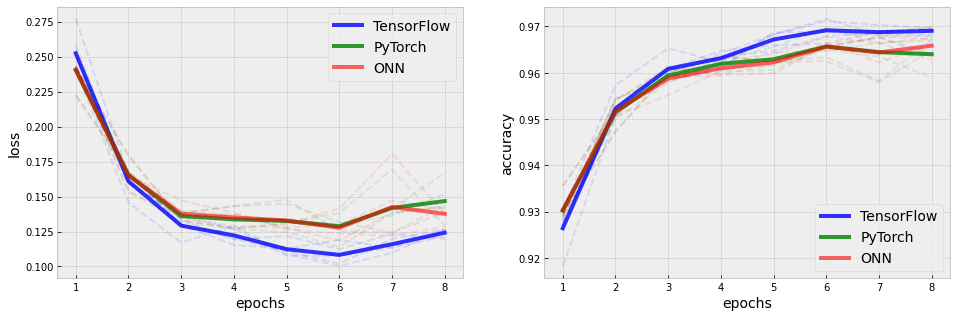

In [445]:
alpha = 0.1
linewidth = 2

with plt.style.context('bmh'):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    #-----------------Loss-----------------#
    r = range(1, EPOCHS + 1)
    
    for i in range(len(SEEDS)):
        axs[0].plot(r, L_ONN[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='red')
        axs[0].plot(r, L_PT[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='green')
        axs[0].plot(r, L_TF[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='blue')
        
    axs[0].plot(r, np.array(L_TF).mean(axis=0), color='blue', label='TensorFlow', alpha=0.8, linewidth=4)
    axs[0].plot(r, np.array(L_PT).mean(axis=0), color='green', label='PyTorch', alpha=0.8, linewidth=4)
    axs[0].plot(r, np.array(L_ONN).mean(axis=0), color='red', label='ONN', alpha=0.6, linewidth=4)
        
    plt.xticks(r)
    axs[0].set_xlabel('epochs', fontsize=14)
    axs[0].set_ylabel('loss', fontsize=14)

    axs[0].legend(fontsize=14)
#-----------------Loss-----------------#

#-----------------Accuracy-----------------#
    for i in range(len(SEEDS)):
        axs[1].plot(r, A_ONN[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='red')
        axs[1].plot(r, A_PT[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='green')
        axs[1].plot(r, A_TF[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='blue')
        
    axs[1].plot(r, np.array(A_TF).mean(axis=0), color='blue', label='TensorFlow', alpha=0.8, linewidth=4)
    axs[1].plot(r, np.array(A_PT).mean(axis=0), color='green', label='PyTorch', alpha=0.8, linewidth=4)
    axs[1].plot(r, np.array(A_ONN).mean(axis=0), color='red', label='ONN', alpha=0.6, linewidth=4)
        
    plt.xticks(r)
    axs[1].set_xlabel('epochs', fontsize=14)
    axs[1].set_ylabel('accuracy', fontsize=14)

    axs[1].legend(fontsize=14)
#-----------------Accuracy-----------------#

#plt.savefig("mnist_test.svg")
plt.show()

`Сравнительная таблица`
___

In [221]:
np.array(A_ONN)[:, 7].mean() * 100

95.73246753246754

In [222]:
np.array(A_PT)[:, 7].mean() * 100

95.74112554112556

In [223]:
np.array(A_TF)[:, 7].mean() * 100

95.73679653679655

# `Learing rate delay illustraion`
___

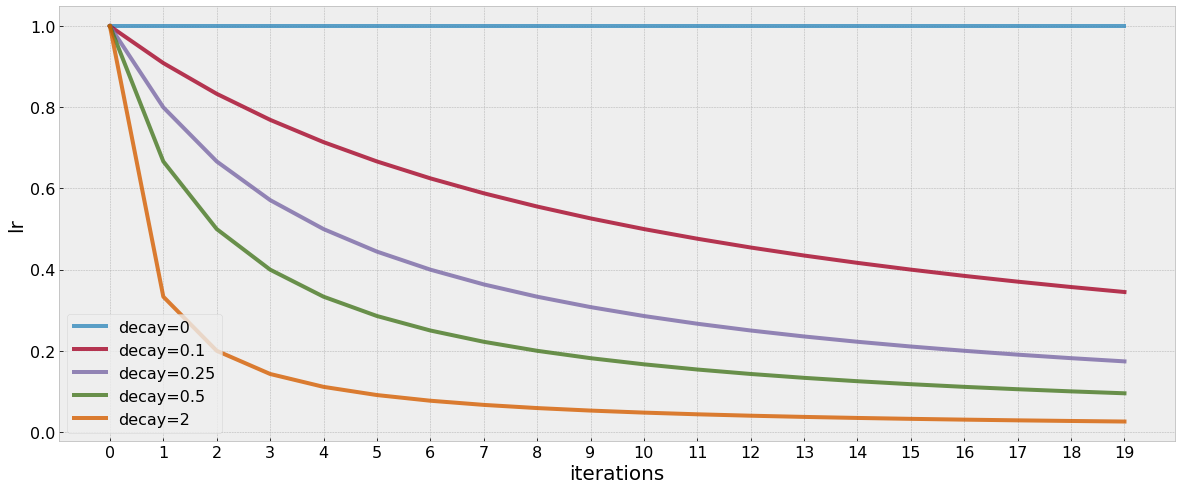

In [642]:
iterations = 20
learning_rates = []
decays = [0, 0.1, 0.25, 0.5, 2]

for decay_ in decays:
    sgd = Optimizer_SGD(learning_rate=1.0, decay=decay_, momentum=0.0)

    learning_rates_decay = [] 

    for i in range(iterations):
        sgd.pre_update_params()
        learning_rates_decay += [sgd.current_learning_rate]
        sgd.post_update_params()
        
    learning_rates += [learning_rates_decay]
    
cnt = 0

with plt.style.context('bmh'):
    plt.figure(figsize=(20, 8))
    for decay_ in decays:
        plt.plot(range(iterations), learning_rates[cnt], label='decay={0}'.format(decay_), linewidth=4, alpha=0.8)
        plt.xlabel('iterations', fontsize=20)
        plt.xticks(range(iterations), fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylabel('lr', fontsize=20)
        plt.legend(fontsize=16)
        cnt += 1
        
    plt.show()

# `California Housing dataset`
___

In [643]:
housing = fetch_california_housing()

In [644]:
housing.data.shape, housing.target.shape

((20640, 8), (20640,))

In [645]:
data = np.array(housing.data.copy())
target = np.array(housing.target.copy())

x_train, x_test, y_train, y_test = \
    train_test_split(
        data,
        target,
        test_size=0.2,
        random_state=42)

In [646]:
x_train.shape, y_train.shape

((16512, 8), (16512,))

In [647]:
x_test.shape, y_test.shape

((4128, 8), (4128,))

___

# `PyTorch on California Housing`
___

In [648]:
def init_train_torch_boston(
    W1, W2, W3,
    B1, B2, B3,
    x_train,
    y_train,
    x_test,
    y_test,
    lr,
    batch_size,
    epochs):
    
    losses = []
    
    model = nn.Sequential(
                nn.Linear(8, 32),
                nn.Sigmoid(),
                nn.Linear(32, 64),
                nn.Sigmoid(),
                nn.Linear(64, 1),
            )
    
    model[0].weight.data = torch.Tensor(W1.T)
    model[0].bias.data = torch.Tensor(B1.reshape(-1, ))

    model[2].weight.data = torch.Tensor(W2.T)
    model[2].bias.data = torch.Tensor(B2.reshape(-1, ))

    model[4].weight.data = torch.Tensor(W3.T)
    model[4].bias.data = torch.Tensor(B3.reshape(-1, ))
    
    loss = nn.MSELoss()
    
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
    # optimizer = torch.optim.Adagrad(model.parameters(), lr=lr, eps=1e-7)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, eps=1e-7, alpha=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps=1e-7, betas=(0.9, 0.999))
    
    #------------------------------------------------------------------#
    
    for _ in range(epochs):
        counter = 0
        while True:
            features = x_train[batch_size * counter:batch_size * (counter + 1), :] 
            labels = y_train[batch_size * counter:batch_size * (counter + 1)]

            if features.shape[0] == 0:
                break

            #--------------#
            optimizer.zero_grad()
            outputs = model(features)
            loss_found = loss(outputs, labels)
            loss_found.backward()
            
            optimizer.step()
            #--------------#

            if (features.shape[0] < batch_size) or (features.shape[0] == x_train.shape[0]):
                break

            counter += 1

        with torch.no_grad():
            outputs = model(x_test)
            loss_found = loss(outputs, y_test)

            losses += [loss_found.item()]
            
    return losses

# `TensorFlow on California Housing`
___

In [649]:
def init_train_tensorflow_boston(
    W1, W2, W3,
    B1, B2, B3,
    x_train,
    y_train,
    x_test,
    y_test,
    lr,
    batch_size,
    epochs):
    
    losses = []
    
    model = keras.Sequential([
        keras.layers.Dense(32, input_shape=(8,), activation='sigmoid'),
        keras.layers.Dense(64, input_shape=(32,), activation='sigmoid'),
        keras.layers.Dense(1, input_shape=(64,))
    ])
    
    model.layers[0].set_weights([W1, B1.reshape(-1, )])
    model.layers[1].set_weights([W2, B2.reshape(-1, )])
    model.layers[2].set_weights([W3, B3.reshape(-1, )])
    
    loss = keras.losses.MeanSquaredError()
    
    # optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0)
    # optimizer = keras.optimizers.Adagrad(learning_rate=lr, epsilon=1e-7, initial_accumulator_value=0)
    # optimizer = keras.optimizers.RMSprop(learning_rate=lr, epsilon=1e-7, rho=0.9)
    optimizer = keras.optimizers.Adam(learning_rate=lr, epsilon=1e-7, beta_1=0.9, beta_2=0.999)
    
    #-----------------------------------------------------------------#
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])    
    
    for _ in range(epochs):
        model.fit(x_train, y_train, epochs=1, batch_size=batch_size, verbose=0)

        losses += [np.mean(loss.call(y_test, model.predict(x_test)))]
        
    return losses

# `ONN on California Housing`
___

In [650]:
def init_train_onn_boston(
    W1, W2, W3,
    B1, B2, B3,
    x_train,
    y_train,
    x_test,
    y_test,
    lr,
    batch_size,
    epochs):
    
    losses = []
    
    model = [
        Layer_Dense(8, 32),
        Activation_Sigmoid(),
        Layer_Dense(32, 64),
        Activation_Sigmoid(),
        Layer_Dense(64, 1)
    ]
    
    model[0].weights = W1.copy()
    model[0].biases = B1.copy()

    model[2].weights = W2.copy()
    model[2].biases = B2.copy()

    model[4].weights = W3.copy()
    model[4].biases = B3.copy()
    
    loss = Loss_MeanSquaredError()
    
    # optimizer = Optimizer_SGD(learning_rate=lr, momentum=0)
    # optimizer = Optimizer_Adagrad(learning_rate=lr, epsilon=1e-7)
    # optimizer = Optimizer_RMSprop(learning_rate=lr, decay=0, epsilon=1e-7, rho=0.9)
    optimizer = Optimizer_Adam(learning_rate=lr, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999)
    #-------------------------------------------------------#
    
    for _ in range(epochs):
        # Training
        counter = 0
        while True:
            features = x_train[batch_size * counter:batch_size * (counter + 1), :] 
            labels = y_train[batch_size * counter:batch_size * (counter + 1)]

            if features.shape[0] == 0:
                break

            #-------Forward pass-------#
            outputs = features.copy()

            for layer in model:
                layer.forward(outputs)
                outputs = layer.output
            #-------Forward pass-------#
            
            #-------Backward pass-------#
            loss.backward(outputs, labels)
            inputs = loss.dinputs

            for layer in reversed(model):
                layer.backward(inputs)
                inputs = layer.dinputs
            #-------Backward pass-------#

            #-------Weights, biases and lr updates -------#
            optimizer.pre_update_params()

            for layer in model:
                if hasattr(layer, 'dweights'):
                    optimizer.update_params(layer)

            optimizer.post_update_params()
            #-------Weights, biases and lr updates -------#

            if (features.shape[0] < batch_size) or (features.shape[0] == x_train.shape[0]):
                break

            counter += 1

        # Testing
        outputs = x_test.copy()

        for layer in model:
            layer.forward(outputs)
            outputs = layer.output

        losses += [loss.calculate(outputs, y_test)]
        
    return losses

# `Testing on California Housing`
___

In [684]:
LR = 1e-3
BATCH = 256
EPOCHS = 20
SEEDS = [1, 13, 508, 362, 5702]

In [685]:
B1 = np.zeros((1, 32))
B2 = np.zeros((1, 64))
B3 = np.zeros((1, 1))

L_ONN, L_TF, L_PT = [], [], []

for S in tqdm(SEEDS):
    np.random.seed(S)

    W1 = 0.01 * np.random.randn(8, 32)
    W2 = 0.01 * np.random.randn(32, 64)
    W3 = 0.01 * np.random.randn(64, 1)
    
    #_________________________________#
    
    losses_tensorflow = \
        init_train_tensorflow_boston(
            W1, W2, W3, B1, B2, B3,
            x_train, y_train.reshape(-1, 1),
            x_test, y_test.reshape(-1, 1),
            lr=LR,
            batch_size=BATCH,
            epochs=EPOCHS)
    
    L_TF += [losses_tensorflow]
    
    losses_onn = \
        init_train_onn_boston(
            W1, W2, W3, B1, B2, B3,
            x_train, y_train.reshape(-1, 1),
            x_test, y_test.reshape(-1, 1),
            lr=LR,
            batch_size=BATCH,
            epochs=EPOCHS)
    
    L_ONN += [losses_onn]
    
    losses_torch = \
        init_train_torch_boston(
            W1, W2, W3, B1, B2, B3,
            torch.tensor(x_train.astype(np.float32)), torch.Tensor(y_train.reshape(-1, 1)),
            torch.tensor(x_test.astype(np.float32)), torch.Tensor(y_test.reshape(-1, 1)),
            lr=LR,
            batch_size=BATCH,
            epochs=EPOCHS)
    
    L_PT += [losses_torch]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]C:\Users\apmil\AppData\Local\Temp/ipykernel_16328/1402231121.py:8: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-inputs))
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:57<00:00, 11.55s/it]


# `Visualizing on California Housing`
___

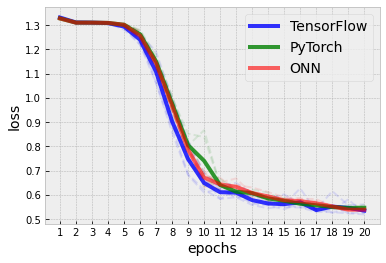

In [698]:
alpha = 0.1
linewidth = 2

with plt.style.context('bmh'):
    #plt.figure(figsize=(14,10))
    
    #-----------------Loss-----------------#
    r = range(1, EPOCHS + 1)
    
    for i in range(len(SEEDS)):
        plt.plot(r, L_ONN[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='red')
        plt.plot(r, L_PT[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='green')
        plt.plot(r, L_TF[i], linestyle='--', alpha=alpha, linewidth=linewidth, color='blue')
        
    plt.plot(r, np.array(L_TF).mean(axis=0), color='blue', label='TensorFlow', alpha=0.8, linewidth=4)
    plt.plot(r, np.array(L_PT).mean(axis=0), color='green', label='PyTorch', alpha=0.8, linewidth=4)
    plt.plot(r, np.array(L_ONN).mean(axis=0), color='red', label='ONN', alpha=0.6, linewidth=4)
        
    plt.xticks(r)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('loss', fontsize=14)

    plt.legend(fontsize=14)
#-----------------Loss-----------------#

#plt.savefig("boston_test.svg")
plt.show()

In [699]:
np.array(L_ONN)[:, 19].mean()

0.5394558982177763

In [700]:
np.array(L_PT)[:, 19].mean()

0.547539222240448

In [701]:
np.array(L_TF)[:, 19].mean()

0.5358044

___